In [1]:
import strax
import straxen
print(straxen.__file__)
import pandas as pd
pd.options.display.max_colwidth = 100
from tqdm import tqdm
import numpy as np

import numba

from scipy.optimize import curve_fit
from scipy import stats

import matplotlib.pyplot as plt

0.0.8
/home/gvolta/XENONnT/straxen/straxen/__init__.py


In [2]:
st = straxen.contexts.strax_workshop_dali()

In [3]:
st.register(straxen.plugins.led_calibration.LEDCalibration)
st.data_info('led_calibration')

,Field name,Data type,Comment
0,area,int32,Area averaged in integration windows
1,amplitudeLED,int32,Amplitude in LED window
2,amplitudeNOISE,int32,Amplitude in off LED window
3,channel,int16,Channel
4,time,int64,Start time of the interval (ns since unix epoch)
5,dt,int16,Time resolution in ns
6,length,int32,Length of the interval in samples


In [4]:
st.show_config('led_calibration')

,option,default,current,applies_to,help
0,LED_window,"(125, 250)",<OMITTED>,"(led_calibration,)",Window (samples) where we expect the signal in LED calibration
1,noise_window,"(350, 475)",<OMITTED>,"(led_calibration,)",Window (samples) to analysis the noise
2,light_level,"(0, 248)",<OMITTED>,"(led_calibration,)","Three different light level for XENON1T: (0,36), (37,126), (127,248). Defalt value: all the PMTs"
3,pax_raw_dir,/data/xenon/raw,<OMITTED>,"(raw_records,)",Directory with raw pax datasets
4,stop_after_zips,0,<OMITTED>,"(raw_records,)",Convert only this many zip files. 0 = all.
5,events_per_chunk,50,<OMITTED>,"(raw_records,)",Number of events to yield per chunk
6,samples_per_record,110,<OMITTED>,"(raw_records,)",Number of samples per record


In [5]:
runs = st.select_runs(run_mode='LED*')

Checking data availability: 100%|██████████| 5/5 [00:13<00:00,  2.95s/it]


In [6]:
runs

,end,mode,name,number,reader.ini.name,start,tags,trigger.events_built,records_available,raw_records_available,peaks_available,events_available,event_info_available
121,2018-02-19 10:00:16+00:00,LED_3mus_stable,180219_0952,16979,LED_3mus_stable,2018-02-19 09:52:13+00:00,"gain_step0,_sciencerun2_candidate",196157.0,False,True,False,False,False
122,2018-02-19 10:09:44+00:00,LED_3mus_stable,180219_1001,16980,LED_3mus_stable,2018-02-19 10:01:41+00:00,"gain_step1,_sciencerun2_candidate",196207.0,False,True,False,False,False
123,2018-02-19 10:19:09+00:00,LED_3mus_stable,180219_1011,16981,LED_3mus_stable,2018-02-19 10:11:06+00:00,"gain_step2,_sciencerun2_candidate",194686.0,False,True,False,False,False
124,2018-02-19 10:29:22+00:00,LED_3mus_stable,180219_1021,16982,LED_3mus_stable,2018-02-19 10:21:18+00:00,"gain_step3,_sciencerun2_candidate",196373.0,False,True,False,False,False
125,2018-02-19 10:39:05+00:00,LED_3mus_stable,180219_1030,16983,LED_3mus_stable,2018-02-19 10:31:02+00:00,"gain_step4,_sciencerun2_candidate",195938.0,False,True,False,False,False
126,2018-02-19 10:58:02+00:00,LED_3mus_stable,180219_1049,16985,LED_3mus_stable,2018-02-19 10:50:00+00:00,"spe_topbulk,_sciencerun2_candidate",194366.0,False,True,False,False,False
127,2018-02-19 11:07:24+00:00,LED_3mus_stable,180219_1059,16986,LED_3mus_stable,2018-02-19 10:59:21+00:00,"spe_topring,_sciencerun2_candidate",193050.0,False,True,False,False,False
128,2018-02-19 11:15:31+00:00,LED_7mus_stable,180219_1110,16987,LED_7mus_stable,2018-02-19 11:10:28+00:00,"Afterpulse,_sciencerun2_candidate",46116.0,False,True,False,False,False
129,2018-02-19 11:31:50+00:00,LED_7mus_stable,180219_1116,16988,LED_7mus_stable,2018-02-19 11:16:48+00:00,"Afterpulse,_sciencerun2_candidate",137431.0,False,True,False,False,False


#### Hist of windows integration by led_calibration plugin

In [7]:
data_lc = st.get_array('180219_1001', 'led_calibration', max_workers=10)

#### Hist of windows integration by raw_records plugin

In [10]:
run_id = '180219_1001'
data_rr = st.get_array(run_id, 'raw_records', max_workers = 10, seconds_range=(0,30))

In [11]:
def get_amplitude(raw_records, LED_window=[125, 250], noise_window=[350, 475]):
    '''
    Needed for the SPE computation.
    Take the maximum in two different regions, where there is the signal and where there is not.
    '''
    on = np.zeros((len(raw_records)), dtype=[('channel','int16'),('amplitudeLED', '<i4')])
    off = np.zeros((len(raw_records)), dtype=[('channel','int16'),('amplitudeNOISE', '<i4')])
    i = 0
    for r in raw_records:
        on['amplitudeLED'][i] = np.max(r['data'][LED_window[0]:LED_window[1]])
        on['channel'][i] = r['channel']
        off['amplitudeNOISE'][i] = np.max(r['data'][noise_window[0]:noise_window[1]])
        off['channel'][i] = r['channel']
        i=i+1
    return on, off

def get_area(raw_records, LED_window=[125, 250]):
    '''
    Needed for the gain computation.
    Sum the data in the defined window to get the area.
    This is done in 6 integration window and it returns the average area.
    '''
    left = LED_window[0]
    end_pos = [LED_window[1]+2*i for i in range(6)]

    Area = np.zeros((len(raw_records)), dtype=[('channel','int16'),('area','float32')])
    for right in end_pos:
        Area['area'] += raw_records['data'][:, left:right].sum(axis=1)
    Area['channel'] = raw_records['channel']
    Area['area'] = Area['area']/float(len(end_pos))
        
    return Area

In [13]:
on, off = get_amplitude(data_rr)
Area = get_area(data_rr)

### Comparison

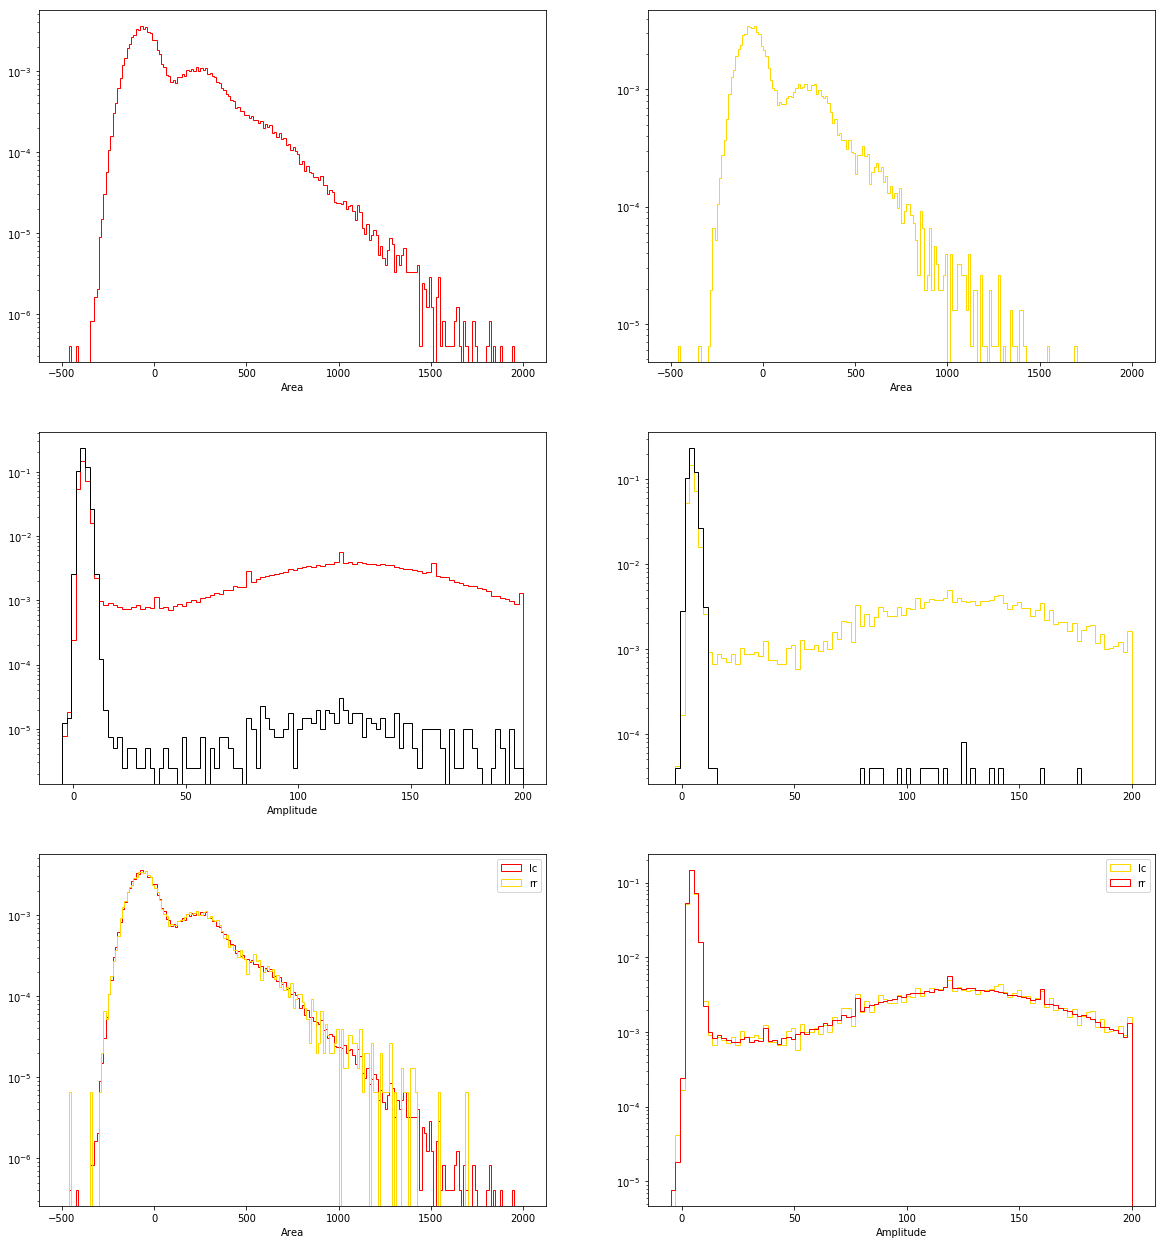

<Figure size 432x288 with 0 Axes>

In [40]:
plt.figure(figsize=(20,22))

plt.subplot(321)
plt.hist(data_lc[data_lc['channel']==6]['area'], bins=200, range=(-500, 2000), 
         color='red', histtype='step', density=True, label='lc')
plt.yscale('log')
plt.xlabel('Area')
#plt.title('led_calibration')

plt.subplot(322)
plt.hist(Area[Area['channel']==6]['area'], bins=200, range=(-500, 2000), 
         color='gold', histtype='step', density=True, label='rr')
plt.yscale('log')
plt.xlabel('Area')
#plt.title('raw_records')

plt.subplot(323)
plt.hist(data_lc[data_lc['channel']==6]['amplitudeLED'], bins=100, range=(-5, 200), 
         color='red', histtype='step', density=True, label='lc')
plt.hist(data_lc[data_lc['channel']==6]['amplitudeNOISE'], bins=100, range=(-5, 200), 
         color='black', histtype='step', density=True, label='lc')
plt.yscale('log')
plt.xlabel('Amplitude')

plt.subplot(324)
plt.hist(on[on['channel']==6]['amplitudeLED'], bins=100, range=(-5, 200), 
         color='gold', histtype='step', density=True, label='rr')
plt.hist(off[off['channel']==6]['amplitudeNOISE'], bins=100, range=(-5, 200), 
         color='black', histtype='step', density=True, label='rr')
plt.yscale('log')
#plt.xlabel('Amplitude')

plt.subplot(325)
plt.hist(data_lc[data_lc['channel']==6]['area'], bins=200, range=(-500, 2000), 
         color='red', histtype='step', density=True, label='lc')
plt.hist(Area[Area['channel']==6]['area'], bins=200, range=(-500, 2000), 
         color='gold', histtype='step', density=True, label='rr')
plt.yscale('log')
plt.xlabel('Area')
plt.legend(loc='best')
#plt.title('raw_records')

plt.subplot(326)
plt.hist(on[on['channel']==6]['amplitudeLED'], bins=100, range=(-5, 200), 
         color='gold', histtype='step', density=True, label='lc')
plt.hist(data_lc[data_lc['channel']==6]['amplitudeLED'], bins=100, range=(-5, 200), 
         color='red', histtype='step', density=True, label='rr')
plt.yscale('log')
plt.xlabel('Amplitude')
plt.legend(loc='best')

plt.show()
plt.tight_layout()